In [1]:
%load_ext autoreload

In [2]:
%autoreload 2

In [3]:
import os
import sys
import random
import glob
import pickle
import itertools
import io
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, accuracy_score
import pandas
import time
from tqdm import tqdm

import sklearn

import tensorflow as tf
import tf_data


In [4]:
import tensorflow as tf
import json, os
import numpy as np

# Tested with TensorFlow 2.1.0
print('version={}, CUDA={}, GPU={}, TPU={}'.format(
    tf.__version__, tf.test.is_built_with_cuda(),
    # GPU attached?
    len(tf.config.list_physical_devices('GPU')) > 0,
    # TPU accessible? (only works on Colab)
    'COLAB_TPU_ADDR' in os.environ))

if len(tf.config.list_physical_devices('GPU')) > 0:
    physical_devices = tf.config.list_physical_devices('GPU')
    tf.config.experimental.set_memory_growth(physical_devices[0], enable=True)
    strategy = tf.distribute.OneDeviceStrategy("gpu:0")

version=2.3.0, CUDA=True, GPU=True, TPU=False


# Dataset building

In [5]:
data_path = {"ele_match": "/eos/user/r/rdfexp/ecal/cluster/output_deepcluster_dumper/windows_data/electrons/recordio_allinfo_v2/training/calo_matched/*.proto",
             "gamma_match": "/eos/user/r/rdfexp/ecal/cluster/output_deepcluster_dumper/windows_data/gammas/recordio_allinfo_v2/training/calo_matched/*.proto",
             "ele_nomatch": "/eos/user/r/rdfexp/ecal/cluster/output_deepcluster_dumper/windows_data/electrons/recordio_allinfo_v2/training/no_calo_matched/*.proto",
             "gamma_nomatch": "/eos/user/r/rdfexp/ecal/cluster/output_deepcluster_dumper/windows_data/gammas/recordio_allinfo_v2/training/no_calo_matched/*.proto"
            }

In [13]:
features = ["cluster_ieta","cluster_iphi","cluster_iz",
            "cluster_deta", "cluster_dphi",
            "en_cluster","et_cluster", 
            "cl_swissCross", "cl_nxtals", "cl_etaWidth","cl_phiWidth"]

In [5]:
def deltaEnergySeedNoBatch(cl_X, cl_hits, is_seed, in_sc, ncls):
    mask_seed = tf.squeeze(is_seed)
    mask_seed.set_shape([None,None])
    seed_en = tf.boolean_mask(cl_X[:,5], mask_seed)
    seed_et = tf.boolean_mask(cl_X[:,6], mask_seed)
    delta_seed_en = (seed_en - cl_X[:,5])[:,tf.newaxis]
    delta_seed_et = (seed_et - cl_X[:,6])[:,tf.newaxis]
    cl_X = tf.concat([cl_X, delta_seed_en, delta_seed_et], axis=-1)
    return cl_X, cl_hits.to_tensor(), is_seed, in_sc, ncls

In [6]:
def deltaEnergySeed(cl_X, cl_hits, is_seed, in_sc, ncls):
    mask_seed = tf.squeeze(is_seed)
    mask_seed.set_shape([None,None])
    seed_en = tf.boolean_mask(cl_X[:,:,5], mask_seed)[:,tf.newaxis]
    seed_et = tf.boolean_mask(cl_X[:,:,6], mask_seed)[:,tf.newaxis]
    delta_seed_en = (seed_en - cl_X[:,:,5])[:,:,tf.newaxis]
    delta_seed_et = (seed_et - cl_X[:,:,6])[:,:,tf.newaxis]
    cl_X = tf.concat([cl_X, delta_seed_en, delta_seed_et], axis=-1)
    return cl_X, cl_hits.to_tensor(), is_seed, in_sc, ncls

In [58]:
_load_n_items = 10
_batch_size = 5
_nepochs = 100
_ntrain = 10000
_nval = 1000

In [59]:
total_ds = tf_data.load_balanced_dataset_batch(data_path, features, _batch_size)

In [60]:
ds_train = total_ds.take(_ntrain).prefetch(100).repeat(_nepochs)
ds_test = total_ds.skip(_ntrain).take(_nval).prefetch(100).repeat(_nepochs)

In [61]:
a = tf_data.get(ds_train)

In [62]:
a

(<tf.Tensor: shape=(5, 3, 12), dtype=float32, numpy=
 array([[[ 3.5000000e+01,  5.7000000e+01, -1.0000000e+00,  0.0000000e+00,
           0.0000000e+00,  1.1738692e+01,  1.8061291e+00,  1.0000000e+00,
           1.0000000e+00,  2.9102231e-03,  1.0418892e-04,  1.0000000e+00],
         [ 4.1000000e+01,  6.1000000e+01, -1.0000000e+00,  1.7219329e-01,
           4.4118524e-01,  5.8205500e+00,  7.5520438e-01,  1.0000000e+00,
           1.0000000e+00,  4.1483766e-03,  1.3613701e-04,  0.0000000e+00],
         [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00,  0.0000000e+00,
           0.0000000e+00,  0.0000000e+00,  0.0000000e+00,  0.0000000e+00,
           0.0000000e+00,  0.0000000e+00,  0.0000000e+00,  0.0000000e+00]],
 
        [[-4.1000000e+01,  1.2400000e+02,  0.0000000e+00,  0.0000000e+00,
           0.0000000e+00,  2.4197176e+00,  1.9102441e+00,  6.0364980e-01,
           3.0000000e+00,  6.4782742e-03,  8.4913494e-03,  1.0000000e+00],
         [-3.7000000e+01,  1.5200000e+02,  0.0000000

# Model building

In [15]:
from model import *
from plotting import * 

In [16]:
graph = GraphBuilding(output_dim_nodes=32)

In [17]:
cl_x, coord, adj, mask,debug = graph(a)

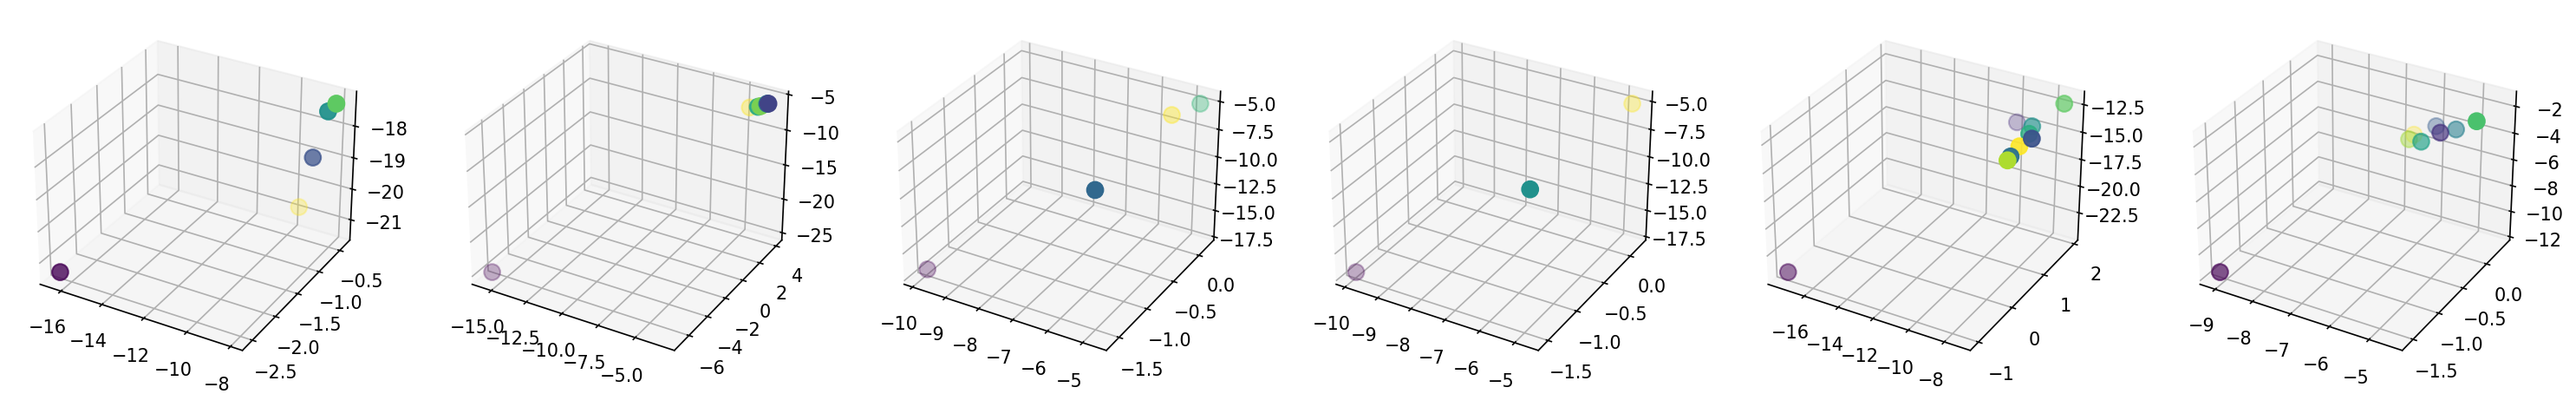

In [18]:
plot3D(coord,mask)

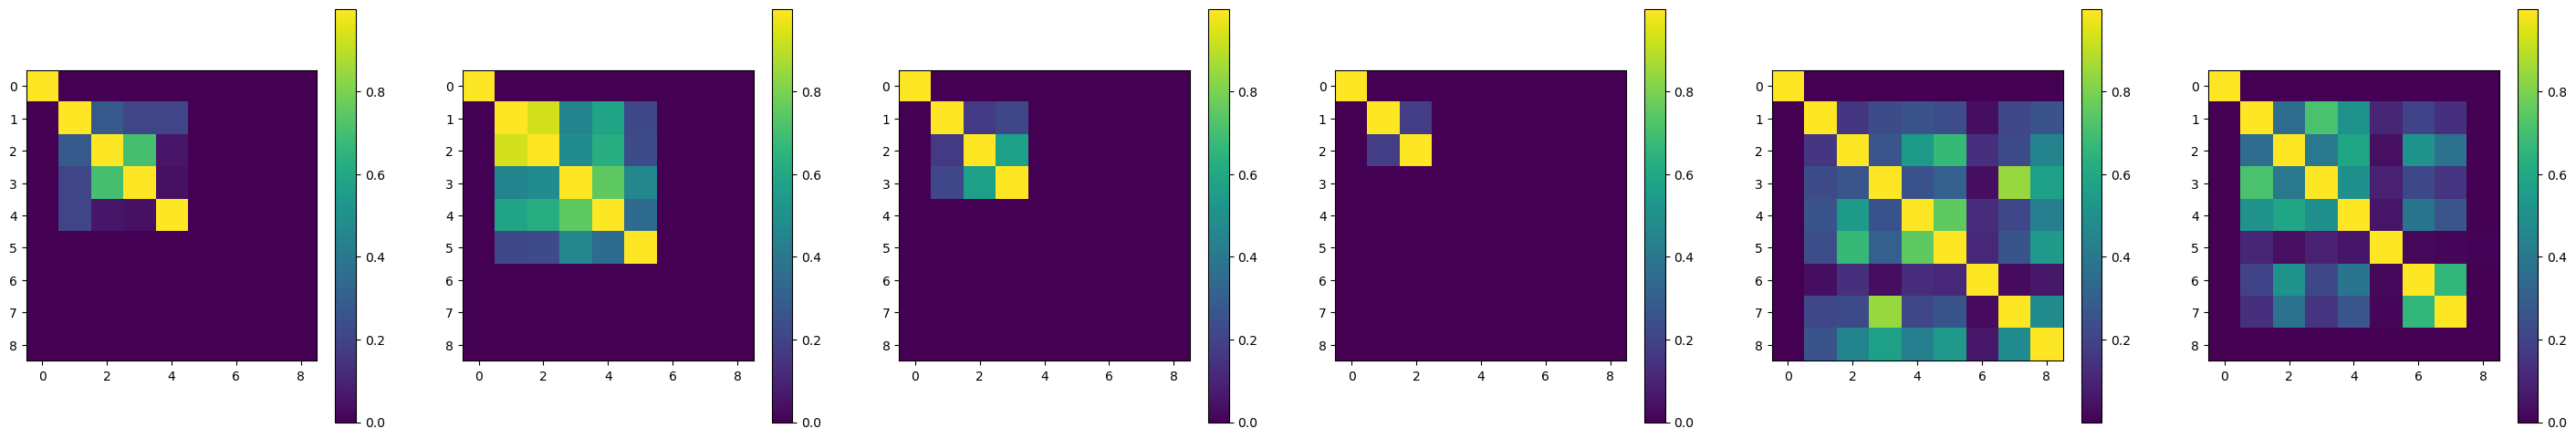

In [19]:
plotM(*adj)

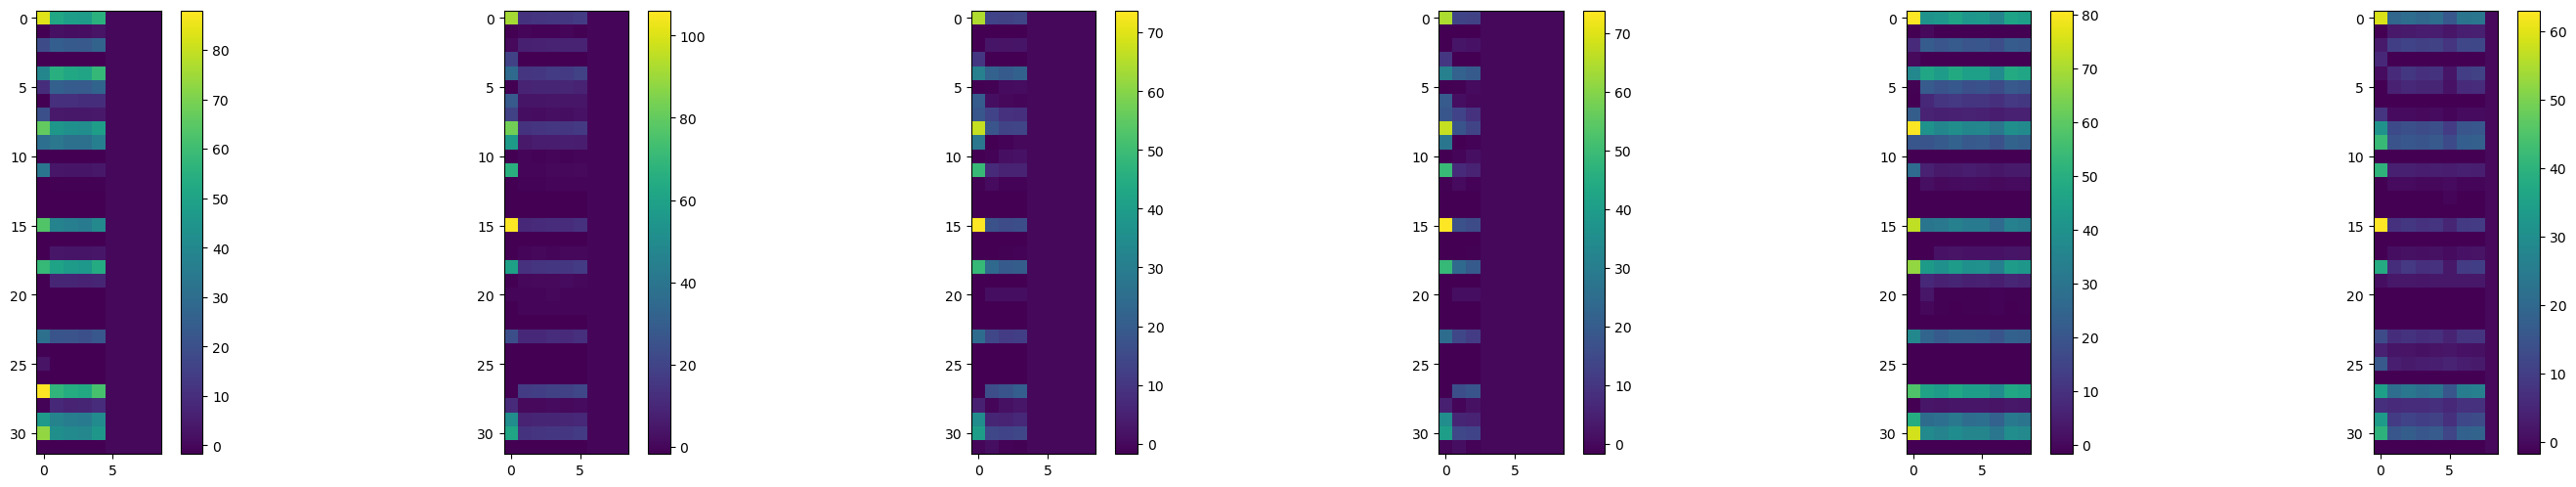

In [20]:
plotM(*cl_x)

In [21]:
class DeepClusterGN(tf.keras.Model):
    
    def __init__(self, **kwargs):
        self.nconv = kwargs.pop("nconv",3)
        self.activation = kwargs.get("activation", tf.nn.selu)
        self.output_dim_nodes = kwargs.get("output_dim_nodes",32)
        self.output_dim_gconv = kwargs.get("output_dim_gconv",self.output_dim_nodes)
        self.output_dim_clclass = kwargs.get("output_dim_clclass",self.output_dim_gconv)
        self.layers_clclass = kwargs.get("layers_clclass",[64,64])
        
        super(DeepClusterGN, self).__init__()
        
        
        self.graphbuild = GraphBuilding(**kwargs)
        self.GCN = GHConvI(n_iter =self.nconv, input_dim=self.output_dim_nodes , hidden_dim=self.output_dim_gconv , activation=self.activation)
        
        self.SA_cl = SelfAttention(self.output_dim_gconv, self.output_dim_clclass, activation=self.activation)
        
        self.dense_clclass = []
        for N in self.layers_clclass:
            self.dense_clclass.append(tf.keras.layers.Dense(N, activation=self.activation))
        self.dense_clclass.append(tf.keras.layers.Dense(1, activation=self.activation))
        
        
    def call(self, inputs, training=True):
        cl_x, coord, adj, mask_cls = graph(a)
        
        out_gcn = self.GCN(cl_x, adj)
        
        out_SA,_ = self.SA_cl(out_gcn, mask_cls)
        
        dense_clclass_X = out_SA
        for dense in self.dense_clclass:  
            dense_clclass_X = dense(dense_clclass_X)
        
        return cl_x, coord, adj, mask_cls ,out_gcn, out_SA, dense_clclass_X
        

In [22]:
dcgn = DeepClusterGN(nconv=3)

In [23]:
cl_x, coord, adj, mask, out_gcn, out_SA, clclass = dcgn(a)

ValueError: too many values to unpack (expected 4)

In [ ]:
plot3D(coord, mask)

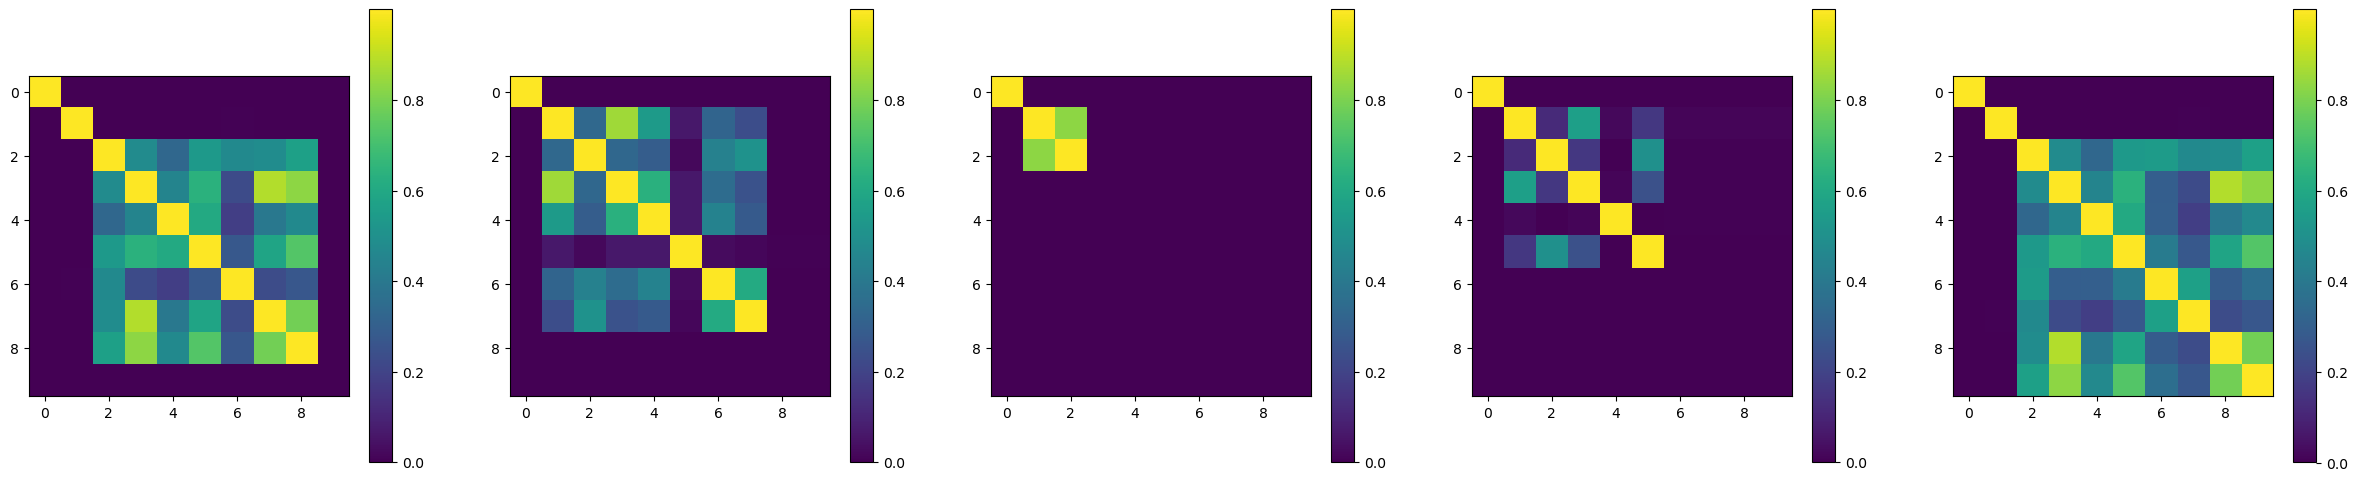

In [209]:
plotM(*adj)

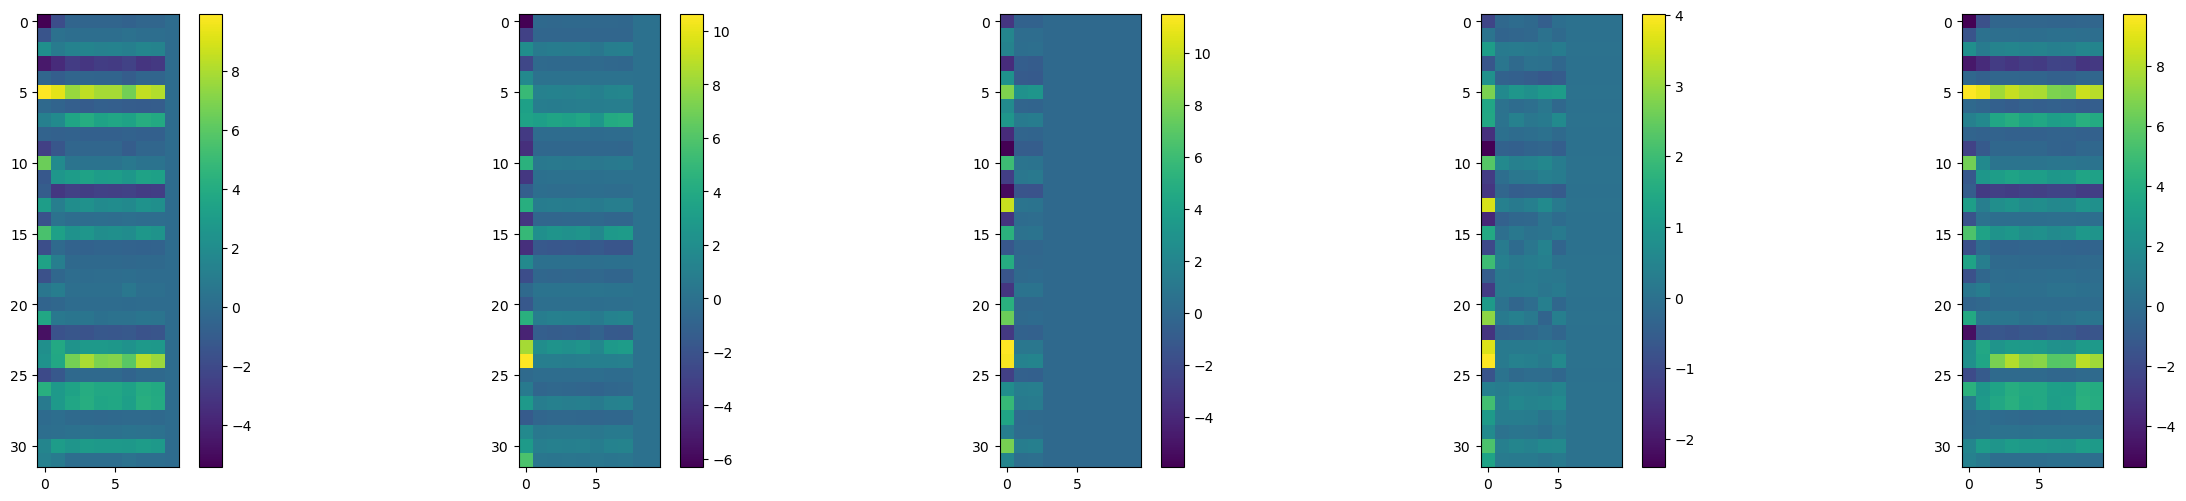

In [231]:
plotM(*out_gcn)

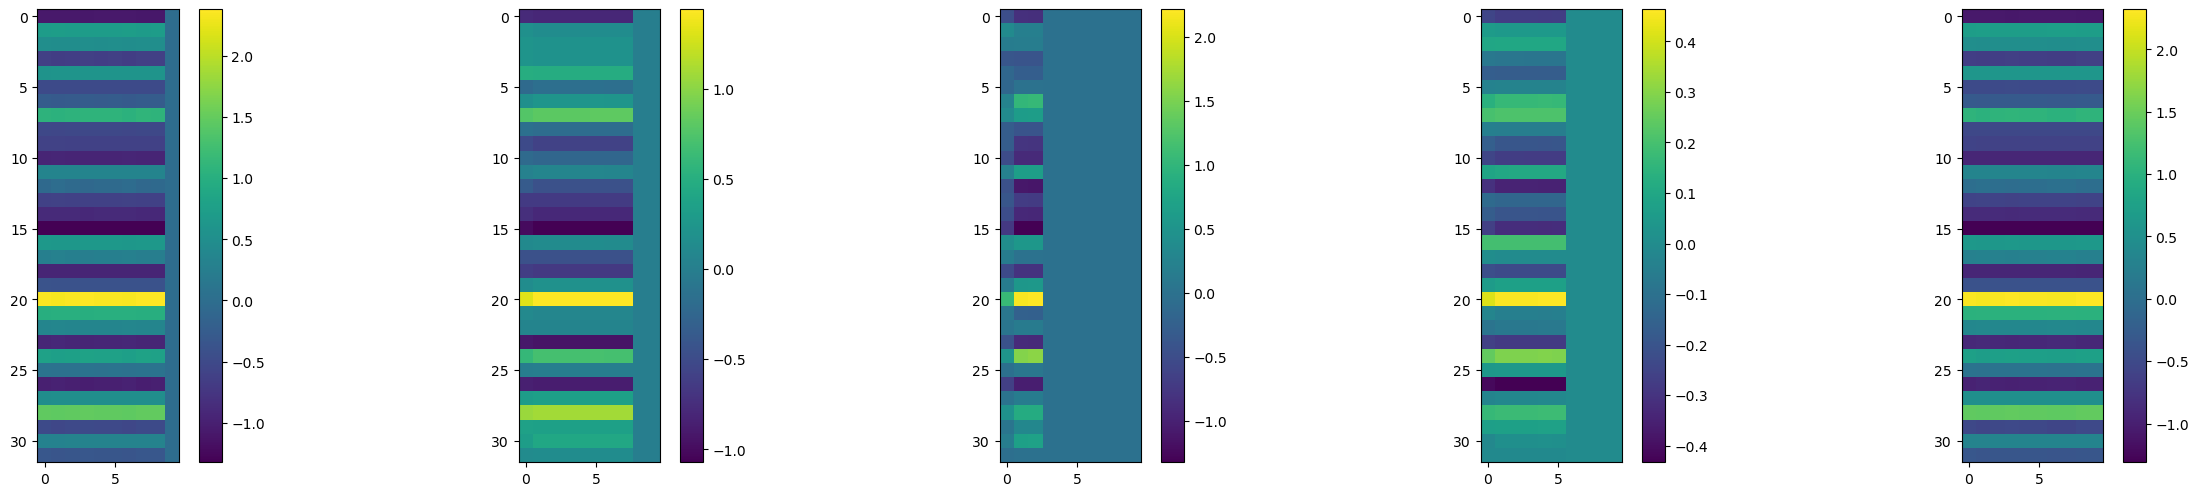

In [244]:
plotM(*out_SA)

In [248]:
clclass

<tf.Tensor: shape=(5, 10, 1), dtype=float32, numpy=
array([[[-0.5667554 ],
        [-0.56589395],
        [-0.5937921 ],
        [-0.59955436],
        [-0.59441876],
        [-0.5956471 ],
        [-0.5882824 ],
        [-0.6002383 ],
        [-0.5981204 ],
        [ 0.        ]],

       [[ 0.1099326 ],
        [ 0.13250989],
        [ 0.13211137],
        [ 0.13261425],
        [ 0.13214192],
        [ 0.13272904],
        [ 0.13158427],
        [ 0.13155283],
        [ 0.        ],
        [ 0.        ]],

       [[-0.5224537 ],
        [-0.46075085],
        [-0.4614584 ],
        [ 0.        ],
        [ 0.        ],
        [ 0.        ],
        [ 0.        ],
        [ 0.        ],
        [ 0.        ],
        [ 0.        ]],

       [[ 0.04554345],
        [ 0.04052685],
        [ 0.04109114],
        [ 0.04082789],
        [ 0.0405314 ],
        [ 0.04113003],
        [ 0.        ],
        [ 0.        ],
        [ 0.        ],
        [ 0.        ]],

       [[-0.5524788 

In [7]:
#Simple message passing based on a matrix multiplication
class DNNSuperCluster(tf.keras.Model):
    
    def __init__(self, activation=tf.nn.relu, 
                     nclass_labels=2, 
                     hidden_dim_coord=256, hidden_dim_input=256, hidden_dim_id=256,     
                     n_layers_input=2, n_layers_id=3, n_layers_coord=2,
                     distance_dim=256, num_conv=4, convlayer="ghconv", dropout=0.1):
        super(DNNSuperCluster, self).__init__()
        self.activation = activation
        self.nclass_labels = nclass_labels

        #self.enc = InputEncoding(3)
        
        # layers for distance coordinate extraction
        self.layers_coord = [ ]
        for i in range(n_layers_coord):
            layer_coord_i = tf.keras.layers.Dense(hidden_dim_coord, activation=activation, name="disctcoords_"+str(i))
            self.layers_coord.append(layer_coord_i)

        self.layer_distcoords = tf.keras.layers.Dense(distance_dim, activation="linear", name="distcoords_final")
        self.layer_distance = Distance(distance_dim, name="distance")

        # layers for feature extraction 
        self.layers_input = [ ]
        for i in range(n_layers_input):
            layer_input_i = tf.keras.layers.Dense(hidden_dim_input, activation=activation, name="input_"+str(i))
            layer_input_i_do = tf.keras.layers.Dropout(dropout)
            self.layers_input.append((layer_input_i, layer_input_i_do))
        
       

        # Graph convolutions
        if convlayer == "sgconv":
            self.layer_conv1 = SGConv(num_conv, hidden_dim_input, activation=activation, name="conv1")
            #self.layer_conv2 = SGConv(num_conv, 2*hidden_dim+len(class_labels), activation=activation, name="conv2")
        elif convlayer == "ghconv":
            self.layer_conv1 = GHConv(num_conv, hidden_dim_input, activation=activation, name="conv1")
            #self.layer_conv2 = GHConv(num_conv, 2*hidden_dim+len(class_labels), activation=activation, name="conv2")

        # Output layers
        self.layers_id = [ ]
        for i in range(n_layers_id):
            layer_id_i = tf.keras.layers.Dense(hidden_dim_id, activation=activation, name="id_"+str(i))
            #layer_id_i_do = tf.keras.layers.Dropout(dropout)
            self.layers_id.append(layer_id_i)
            
        #self.layer_id3 = tf.keras.layers.Dense(hidden_dim, activation=activation, name="id3")
        self.layer_id = tf.keras.layers.Dense(nclass_labels, activation="linear", name="out_id")
        
 
    def predict_distancematrix(self, inputs, msk_elem, training=True):
        x = inputs
        for layer_coord in self.layers_coord:
            x = layer_coord(x)

        distcoords = self.layer_distcoords(x)

        dm = self.layer_distance(distcoords, distcoords)
        
        dm = dm*msk_elem

        return dm

    #@tf.function(input_signature=[tf.TensorSpec(shape=[None, 15], dtype=tf.float32)])
    def call(self, inputs, training=True):
        # separate cluster energies from rescaled inputs
        X = inputs[:,:,1:]
        cl_energies = inputs[:,:,0]
        
        # the 4th element in the scaled input is the en_cluster. used to check for the mask
        msk_input = tf.expand_dims(tf.cast(X[:, :, 3] != 0., tf.float32), -1)

        dm = self.predict_distancematrix(X, msk_elem=msk_input, training=training)
        
        x = X
        for layer_input, layer_input_do in self.layers_input:
            x = layer_input(x)
            x = layer_input_do(x, training)
            
        x = self.layer_conv1(x, dm)
        
        for layer_id in self.layers_id:
            x = layer_id(x)
            #x = layer_id_do(x, training)
            
        out_id_logits = self.layer_id(x)
        
        energies = tf.expand_dims(cl_energies, axis=-1)
        # add the cluster energies in the output, in the future we can add here corrections
        output = tf.concat([out_id_logits,energies], axis=-1)
        # mask to 0 the padded output
        output_masked = output * msk_input
        
        #return masked output logits and the predicted total energy
        return output_masked

# Loss definition

In [8]:
#@tf.function
def separate_true(y, nclass_labels):
    # one-hot encoding for true label (signal,PU,noise)
    # the padded elements have -1 so they are one_hot to (0,0)
    y_onehot = tf.one_hot(tf.cast(y[:,1:], tf.int32), nclass_labels)
    true_en = y[:,0]
    return y_onehot, true_en

#@tf.function
def true_mask(y):
    # mask for elements that should be included in supercluster
    in_sc = tf.cast(y[:,1:] == 1., tf.float32)
    # number of padding elements
    padded = tf.reduce_sum(tf.cast(y[:,1:] == -1., tf.float32), axis=-1)
    return in_sc, padded
    
#@tf.function
def separate_pred(ypred):
    ens = ypred[:,:,2]
    ypred_onehot = ypred[:,:,:2]
    # 0 not include in energy sum, 1 include in energy sum
    # masked elements have pred_id=0 so they do not enter in the energy sum
    pred_id = tf.cast(tf.argmax(ypred_onehot, axis=-1), tf.float32)
    # predicted total energy
    pred_en =  tf.reduce_sum( ens * pred_id, axis=-1)
    # one-hot encoding for true label (signal,PU,noise)
    return ypred_onehot, pred_en, pred_id
    

In [10]:
#@tf.function
def mse_unreduced(true, pred):
    return tf.math.pow(true-pred,2)

#@tf.function
def msle_unreduced(true, pred):
    return tf.math.pow(tf.math.log(tf.math.abs(true) + 1.0) - tf.math.log(tf.math.abs(pred) + 1.0), 2)


#@tf.function
def my_loss_full(y_true, y_pred):
    y_true_onehot, true_en = separate_true(y_true, args.nclass_labels)
    y_pred_onehot, pred_en, pred_id = separate_pred(y_pred)
    # since the padded y_true is -1 -> it gives [0,0] when it is onehot. The ypred for batched is [0,0] so the loss
    # is automatically 0 for padded samples
    l1 = tf.nn.softmax_cross_entropy_with_logits(y_true_onehot, y_pred_onehot)
    
    # true energy loss
    mask_outsc = tf.cast(true_en == 0., tf.float32)
    mask_insc = tf.cast(true_en != 0., tf.float32)
    n_outsc = tf.reduce_sum(mask_outsc)
    n_insc = tf.reduce_sum(mask_insc)
    
    l2_en = mse_unreduced(true_en, pred_en)
    l2_en_log = msle_unreduced(true_en, pred_en)
    
    # separate mean resolution for windows with Caloparticle or not
    l2_en_outsc = tf.reduce_sum(l2_en * mask_outsc) / n_outsc
    l2_en_insc = tf.reduce_sum(l2_en * mask_insc) / n_insc
    l2_en_outsc_log = tf.reduce_sum(l2_en_log * mask_outsc) / n_outsc
    l2_en_insc_log = tf.reduce_sum(l2_en_log * mask_insc) / n_insc
    
    ltot = 2e4*tf.reduce_mean(l1) + 20* l2_en_insc +   10*l2_en_outsc + 200* l2_en_insc_log  + 100* l2_en_outsc_log
    
    return ltot


In [10]:
def energy_resolution_outsc(y_true, y_pred):
    y_true_onehot, true_en = separate_true(y_true, args.nclass_labels)
    y_pred_onehot, pred_en, pred_id = separate_pred(y_pred)
    mask_outsc = tf.cast(true_en == 0., tf.float32)
    n_outsc = tf.reduce_sum(mask_outsc)
    return tf.reduce_sum(mse_unreduced(true_en, pred_en)*mask_outsc) / n_outsc

def energy_resolution_insc(y_true, y_pred):
    y_true_onehot, true_en = separate_true(y_true, args.nclass_labels)
    y_pred_onehot, pred_en, pred_id = separate_pred(y_pred)
    mask_insc = tf.cast(true_en != 0., tf.float32)
    n_insc = tf.reduce_sum(mask_insc)
    return tf.reduce_sum(mse_unreduced(true_en, pred_en)*mask_insc) / n_insc

def energy_resolution_outsc_log(y_true, y_pred):
    y_true_onehot, true_en = separate_true(y_true, args.nclass_labels)
    y_pred_onehot, pred_en, pred_id = separate_pred(y_pred)
    mask_outsc = tf.cast(true_en == 0., tf.float32)
    n_outsc = tf.reduce_sum(mask_outsc)
    return tf.reduce_sum(msle_unreduced(true_en, pred_en)*mask_outsc) / n_outsc

def energy_resolution_insc_log(y_true, y_pred):
    y_true_onehot, true_en = separate_true(y_true, args.nclass_labels)
    y_pred_onehot, pred_en, pred_id = separate_pred(y_pred)
    mask_insc = tf.cast(true_en != 0., tf.float32)
    n_insc = tf.reduce_sum(mask_insc)
    return tf.reduce_sum(msle_unreduced(true_en, pred_en)*mask_insc) / n_insc

In [11]:
def get_tpfn_metrics(y_true, y_pred):
    y_true_mask, n_padded = true_mask(y_true)
    y_false_mask = (tf.cast(y_true_mask == 0., tf.float32))
    
    # pred_id contains the last n_padded elements to 0 that will be always True negatives
    y_pred_onehot, pred_en, pred_id = separate_pred(y_pred)
    
    n_pos = tf.reduce_sum(y_true_mask, axis=-1)
    n_neg = tf.reduce_sum(y_false_mask, axis=-1) - n_padded
    
    n_tot = n_neg + n_pos
    
    true_pos = tf.reduce_sum(pred_id * y_true_mask, axis=-1)
    false_neg = n_pos - true_pos
    
    false_pos = tf.reduce_sum(pred_id * y_false_mask, axis=-1)
    true_neg = n_neg - false_pos
    
    return n_tot, true_pos, false_neg, false_pos, true_neg, 

In [12]:
def precision(tp,tn,fp,fn):
    return tp/(tp+fp)

def recall(tp,tn,fp,fn):
    return tp/(tp+fn)

def accuracy(tp,tn,fp,fn):
    return (tp+tn)/(tp+tn+fp+fn)

In [13]:
class Precision(tf.keras.metrics.Metric):

    def __init__(self, name='precision', **kwargs):
        super(Precision, self).__init__(name=name, **kwargs)
        self.tp = self.add_weight(name='tp', initializer='zeros')
        self.fp = self.add_weight(name='fp', initializer='zeros')

    def update_state(self, y_true, y_pred, sample_weight=None):
        n_tot, true_pos, false_neg, false_pos, true_neg = get_tpfn_metrics(y_true, y_pred)
        self.tp.assign_add(tf.reduce_sum(true_pos))
        self.fp.assign_add(tf.reduce_sum(false_pos))

    def result(self):
        return self.tp / (self.tp + self.fp)

    def reset_states(self):
        self.tp.assign(0)
        self.fp.assign(0)
        
class Recall(tf.keras.metrics.Metric):

    def __init__(self, name='recall', **kwargs):
        super(Recall, self).__init__(name=name, **kwargs)
        self.tp = self.add_weight(name='tp', initializer='zeros')
        self.fn = self.add_weight(name='fn', initializer='zeros')

    def update_state(self, y_true, y_pred, sample_weight=None):
        n_tot, true_pos, false_neg, false_pos, true_neg = get_tpfn_metrics(y_true, y_pred)
        self.tp.assign_add(tf.reduce_sum(true_pos))
        self.fn.assign_add(tf.reduce_sum(false_neg))

    def result(self):
        return self.tp / (self.tp + self.fn)

    def reset_states(self):
        self.tp.assign(0)
        self.fn.assign(0)


### Settings

In [14]:
data_path = "/storage/ECAL/training_data/window_data/electrons/recordio_v4"
models_path = "/storage/ECAL/deepcluster/models/gcn_models_v9/"

#rain_steps_per_epoch = 
#eval_steps_per_epoch = 3e5 // batch_size
from collections import namedtuple
Args = namedtuple('args', [ 'models_path', 'load','nepochs','ntrain','nval','nfeatures',
                            'n_seed_features','batch_size','lr_decay','lr',
                            'hidden_dim_input','hidden_dim_coord', 'hidden_dim_id',
                            'n_layers_input', 'n_layers_id', 'n_layers_coord',
                           'distance_dim','num_conv','dropout','convlayer',
                           'nclass_labels', 'opt'])

args = Args( 
models_path = models_path,
load = False,
nepochs = 100,
ntrain = 1000000,
nval = 200000,
nfeatures = 13,
n_seed_features = 12,
lr_decay = 0.5,
lr = 1e-4,
batch_size = 70,
n_layers_input = 3,
n_layers_id = 3,
n_layers_coord = 3,
hidden_dim_input = 200,
hidden_dim_coord = 200,
hidden_dim_id = 200,
distance_dim = 200,
num_conv = 2,
dropout = 0.2,
convlayer = 'sgconv',
nclass_labels=2,
opt='adam'
        )

### Dataset loading

In [15]:
def scale_features_clusters(X):
    '''
    'is_seed',"cluster_deta", "cluster_dphi", "en_cluster", "et_cluster",
    "cl_f5_r9", "cl_f5_sigmaIetaIeta","cl_f5_sigmaIetaIphi","cl_f5_sigmaIphiIphi",
    "cl_f5_swissCross", "cl_nxtals", "cl_etaWidth", "cl_phiWidth
    '''
    x_mean = tf.constant( 
        [   0.,  -7.09402501e-04, -1.27142875e-04,  1.30375508e+00,  5.67249500e-01, 
            1.92096066e+00,  1.31476120e-02,  1.62948213e-05,  1.42948806e-02,
            5.92920497e-01,  1.49597644e+00,  3.36213188e-03,  3.06446267e-03]
        )

    x_scale = tf.constant(
        [  1.,  1.10279784e-01, 3.30488055e-01, 2.62605247e+00, 1.16284769e+00,
            7.81094814e+00, 1.70392176e-02, 3.05995567e-04, 1.80176053e-02,
            1.99316624e+00, 1.88845046e+00, 4.12315715e-03, 4.79639033e-03]       
        )
    return (X-x_mean)/ x_scale

def scale_features_seed(X):
    '''
     "seed_eta", "seed_iz","en_seed","et_seed",
     "seed_f5_r9", "seed_f5_sigmaIetaIeta","seed_f5_sigmaIetaIphi","seed_f5_sigmaIphiIphi",
     "seed_f5_swissCross","seed_nxtals", "seed_etaWidth", "seed_phiWidth",
    '''
    x_mean = tf.constant( 
        [   6.84241156e-03,  1.62242679e-03,  5.81495577e+01,  2.57215845e+01, 
            1.00772582e+00,  1.35803461e-02, -4.29317013e-06,  1.71072024e-02,
            4.90466869e-01,  5.10511982e+00,  8.82101138e-03,  1.04095965e-02 ]
    
        )

    x_scale = tf.constant(
        [   1.31333380e+00, 5.06988411e-01, 9.21157365e+01, 2.98580765e+01, 
            1.17047757e-01, 1.11969442e-02, 1.86572967e-04, 1.31036359e-02,
            4.01511744e-01, 5.67007350e+00, 6.14304203e-03, 7.24808860e-03]       
        )
    return (X-x_mean)/ x_scale

In [16]:
def _parse_tfr_element(element):
    parse_dic = {
        'X':      tf.io.FixedLenFeature([], tf.string),
        'X_seed': tf.io.FixedLenFeature([], tf.string),
        'y':      tf.io.FixedLenFeature([], tf.string),
        'n_clusters': tf.io.FixedLenFeature([], tf.int64)
    }
    example_message = tf.io.parse_single_example(element, parse_dic)

    X = example_message['X']
    X_seed = example_message['X_seed']
    y = example_message['y']
    nclusters = example_message['n_clusters']
    
    arr_X = tf.io.parse_tensor(X, out_type=tf.float32)
    arr_X_seed = tf.io.parse_tensor(X_seed, out_type=tf.float32)
    arr_y = tf.io.parse_tensor(y, out_type=tf.float32)
    
    #https://github.com/tensorflow/tensorflow/issues/24520#issuecomment-577325475
    arr_X.set_shape(     tf.TensorShape((None, args.nfeatures)))
    arr_X_seed.set_shape(tf.TensorShape((1, args.n_seed_features)))
    arr_y.set_shape(     tf.TensorShape((None,)))
 
    return arr_X, arr_X_seed, nclusters, arr_y
  
def _stack_seed_features(arr_X, arr_X_seed, nclusters, arr_y):
    en_clusters = tf.expand_dims(arr_X[:,3], axis=-1)
    rescaled_X = scale_features_clusters(arr_X)
    rescaled_X_seed = scale_features_seed(arr_X_seed)
    X = tf.concat([en_clusters, rescaled_X, tf.broadcast_to(rescaled_X_seed,[nclusters,rescaled_X_seed.shape[1]] )],
                  axis=1)
    return X,arr_y

In [17]:
# padding shape
ps = ([None,args.nfeatures+args.n_seed_features+1],[None,])

# Create datasets from TFRecord files.
dataset = tf.data.TFRecordDataset(tf.io.gfile.glob('{}/training-*'.format(data_path)))
dataset = dataset.map(_parse_tfr_element,num_parallel_calls=tf.data.experimental.AUTOTUNE)
dataset = dataset.map(_stack_seed_features,num_parallel_calls=tf.data.experimental.AUTOTUNE) # deterministic=False in TFv2.3
dataset = dataset.shuffle(10000, reshuffle_each_iteration=True)

ds_train = dataset.take(args.ntrain).padded_batch(args.batch_size, padded_shapes=ps, drop_remainder=True,padding_values=(0.,-1.))
ds_test = dataset.skip(args.ntrain).take(args.nval).padded_batch(args.batch_size, padded_shapes=ps, drop_remainder=True,padding_values=(0.,-1.))

ds_train_r = ds_train.repeat(args.nepochs)
ds_test_r = ds_test.repeat(args.nepochs)


In [18]:
idata = iter(ds_train)
d = next(idata)

In [19]:
msk_input = tf.expand_dims(tf.cast(d[0][:, :, 3] != 0., tf.float32), -1)

In [21]:
def get_unique_run():
    previous_runs = os.listdir(args.models_path)
    if len(previous_runs) == 0:
        run_number = 1
    else:
        run_number = max([int(s.split('run_')[1]) for s in previous_runs]) + 1
    return run_number

In [22]:
if args.lr_decay > 0:
        #lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
        #    args.lr,
        #    decay_steps=int(args.ntrain//args.batch_size),
        #    decay_rate=args.lr_decay
        #)
        lr_schedule = tf.keras.optimizers.schedules.InverseTimeDecay(
            args.lr,
            decay_steps=int(args.ntrain//args.batch_size),
            decay_rate=args.lr_decay
        )
else:
    lr_schedule = args.lr


In [23]:
with strategy.scope():
    opt = tf.keras.optimizers.Adam(learning_rate=lr_schedule)
    
    model = DNNSuperCluster(hidden_dim_input=args.hidden_dim_input,hidden_dim_coord=args.hidden_dim_coord,
                            hidden_dim_id=args.hidden_dim_id, 
                            n_layers_input=args.n_layers_input, n_layers_id=args.n_layers_id, n_layers_coord=args.n_layers_coord,
                            nclass_labels=args.nclass_labels, 
                            distance_dim=args.distance_dim, 
                            num_conv=args.num_conv, convlayer=args.convlayer, dropout=args.dropout)
   

In [24]:
if not os.path.isdir(args.models_path):
    os.makedirs(args.models_path)

name =  'run_{:02}'.format(get_unique_run())

outdir = args.models_path + name

if os.path.isdir(outdir):
    print("Output directory exists: {}".format(outdir), file=sys.stderr)

print(outdir)

/storage/ECAL/deepcluster/models/gcn_models_v9/run_22


In [25]:
callbacks = []
tb = tf.keras.callbacks.TensorBoard(
    log_dir=outdir, histogram_freq=2, 
    write_graph=False, 
    write_images=True,
    update_freq='epoch',
    profile_batch=0,
)
tb.set_model(model)
callbacks += [tb]

terminate_cb = tf.keras.callbacks.TerminateOnNaN()
callbacks += [terminate_cb]

cp_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=outdir + "/weights.{epoch:02d}-{val_loss:.6f}.hdf5",
    save_weights_only=True,
    verbose=0
)
cp_callback.set_model(model)
callbacks += [cp_callback]

loss_fn = my_loss_full



NameError: name 'outdir' is not defined

In [26]:
with strategy.scope():
    model.compile(optimizer=args.opt, loss=loss_fn,
        metrics=[Precision(),Recall(), energy_resolution_insc,energy_resolution_outsc,
                     energy_resolution_insc_log,energy_resolution_outsc_log,])

    for X, y in ds_train:
        ypred = model(X)
        l = loss_fn(y, ypred)
        break

    

In [27]:
yoh,true_en = separate_true(y, args.nclass_labels)

In [28]:
ypred

<tf.Tensor: shape=(70, 18, 3), dtype=float32, numpy=
array([[[-1.2423130e+00, -8.3294290e-01,  2.4955025e+00],
        [-2.2360535e-01,  5.4161513e-01,  1.4691534e+00],
        [-4.8525473e-01, -1.3082337e+00,  1.4982151e+00],
        ...,
        [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00],
        [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00],
        [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00]],

       [[-3.9056835e+00,  5.4643817e-02,  7.6484070e+01],
        [-2.5258619e-01,  2.5784402e+00,  5.5179367e+00],
        [-5.2430302e-01,  9.2965436e-01,  1.8009961e+00],
        ...,
        [ 3.3698130e-01, -2.0828109e+00,  3.1105274e-01],
        [ 1.3320040e+00, -6.4202666e-01,  2.3348083e-01],
        [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00]],

       [[-2.4870245e+00, -2.4266033e+00,  7.0290855e+01],
        [-1.7524647e+00,  2.5555265e+00,  1.1542038e+01],
        [ 8.5908633e-01, -1.0591314e+00,  6.2240553e-01],
        ...,
        [ 0.0000000e+00,  0.000000

In [29]:
model.summary()

Model: "dnn_super_cluster"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
disctcoords_0 (Dense)        multiple                  5200      
_________________________________________________________________
disctcoords_1 (Dense)        multiple                  40200     
_________________________________________________________________
disctcoords_2 (Dense)        multiple                  40200     
_________________________________________________________________
distcoords_final (Dense)     multiple                  40200     
_________________________________________________________________
distance (Distance)          multiple                  0         
_________________________________________________________________
input_0 (Dense)              multiple                  5200      
_________________________________________________________________
dropout (Dropout)            multiple            

In [24]:
if args.load:
    #ensure model input size is known
    for X, y in ds_train:
        model(X)
        break

    model.load_weights(args.load)
if args.nepochs > 0:
    ret = model.fit(ds_train_r,
        validation_data=ds_test_r, epochs=args.nepochs,
        steps_per_epoch=args.ntrain//args.batch_size, validation_steps=args.nval//args.batch_size,
        verbose=True,
        callbacks=callbacks
    )

Train for 14285 steps, validate for 2857 steps
Epoch 1/100
14285/14285 [==============================] - 527s 37ms/step - loss: 1298.1055 - precision: 0.9225 - recall: 0.8466 - energy_resolution_insc: 23.9094 - energy_resolution_outsc: 15.7657 - energy_resolution_insc_log: 0.2104 - energy_resolution_outsc_log: 0.1599 - val_loss: 954.2882 - val_precision: 0.9189 - val_recall: 0.8836 - val_energy_resolution_insc: 9.8461 - val_energy_resolution_outsc: 18.8330 - val_energy_resolution_insc_log: 0.1814 - val_energy_resolution_outsc_log: 0.1595
Epoch 2/100
14285/14285 [==============================] - 507s 36ms/step - loss: 1053.8019 - precision: 0.9294 - recall: 0.8669 - energy_resolution_insc: 15.6440 - energy_resolution_outsc: 15.8080 - energy_resolution_insc_log: 0.2069 - energy_resolution_outsc_log: 0.1428 - val_loss: 952.2630 - val_precision: 0.9280 - val_recall: 0.8707 - val_energy_resolution_insc: 10.5663 - val_energy_resolution_outsc: 16.5959 - val_energy_resolution_insc_log: 0.204

In [ ]:
str(args)

In [ ]:
with open(outdir + "/args.txt",'w') as config:
    config.write(str(args))
    

In [ ]:
from numba import cuda 
device = cuda.get_current_device()
device.reset()